<a href="https://colab.research.google.com/github/petergchang/sarkka-jax/blob/main/Ch6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#6. General Gaussian Filtering

This notebook replicates the figures of Chapter 6 of  Särkkä's "Bayesian Filtering and Smoothing" using JAX.

To avoid clutter, the following refactorings have been performed:
* All the plotting functions are stored in `plotting.py`.
* After its initial demonstration, any redundant data simulation is stored in `simulations.py`.
* Any miscellaneous simple utility function that is reused is stored in `utils.py`.

Simo Särkkä (2013), “Bayesian Filtering and Smoothing,” Cambridge University Press. Available: https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf

This JAX translation is by Peter G. Chang ([@petergchang](https://github.com/petergchang))



## 6.0 Imports and Pendulum Simulation

In [1]:
!git clone https://github.com/petergchang/sarkka-jax.git
%cd sarkka-jax
!pip install -e .

Cloning into 'sarkka-jax'...
remote: Enumerating objects: 377, done.
remote: Counting objects: 100% (264/264), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 377 (delta 151), reused 164 (delta 88), pack-reused 113
Receiving objects: 100% (377/377), 1.93 MiB | 18.27 MiB/s, done.
Resolving deltas: 100% (196/196), done.
/content/sarkka-jax
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/sarkka-jax
     |████████████████████████████████| 72 kB 534 kB/s 
  Running setup.py develop for ssm-jax


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap
from jax import lax
from jax import jacfwd

import simulations as sim
import plotting as plot
import utils as utils

In [3]:
dt = 0.0125
params = sim.pendulum_default_params(dt=dt)
states, obs = sim.simulate_pendulum_with_default_params(dt=dt)

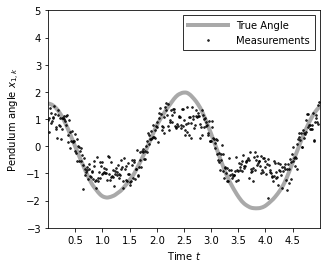

In [4]:
# Create time grid for plotting
time_grid = jnp.arange(0.0, 5.0, step=dt)

# Plot the generated data
plot.plot_pendulum(time_grid, states[:,0], obs)

##6.4 Gauss–Hermite Kalman Filter

In [14]:
from numpy.polynomial.hermite_e import hermegauss
from sklearn.utils.extmath import cartesian

# Additive GHKF (Algorithm 6.7)
def ghkf_additive(m_0, P_0, f, h, Q, R, p, Y):
    num_timesteps, n = len(Y), P_0.shape[0]

    # Compute sigmas and weights
    samples_1d, weights_1d = hermegauss(p)
    weights_1d /= weights_1d.sum()
    sigmas = cartesian(jnp.array([samples_1d] * n))
    weights = jnp.prod(cartesian(jnp.array([weights_1d] * n)), axis=1)

    # Helper function
    def compute_sigmas(m, P, sigmas):
        # Slightly convoluted way in order to preserve desired dimensions
        disc = jax.vmap(jnp.matmul, [None,0], 0)(jnp.linalg.cholesky(P), sigmas)
        return jax.vmap(jnp.add, [None,0], 0)(m, disc)

    def _step(carry, t):
        m_k, P_k = carry

        # Prediction step:
        # 1. Form sigma points
        sigmas_pred = compute_sigmas(m_k, P_k, sigmas)
        # 2. Propagate the sigma points
        sigmas_pred = jax.vmap(f, 0, 0)(sigmas_pred)
        # 3. Compute predicted mean and covariance
        m_pred = jnp.tensordot(weights, sigmas_pred, axes=1)
        outer = lambda x, y: jnp.atleast_2d(x).T @ jnp.atleast_2d(y)
        outer = jax.vmap(outer, 0, 0)
        P_pred = jnp.tensordot(weights, 
                               outer(sigmas_pred-m_pred, sigmas_pred-m_pred), 
                               axes=1) + Q

        # Update step:
        # 1. Form sigma points
        sigmas_update = compute_sigmas(m_pred, P_pred, sigmas)
        # 2. Propagate the sigma points
        sigmas_update_prop = jax.vmap(h, 0, 0)(sigmas_update)
        # 3. Compute params
        mu = jnp.tensordot(weights, sigmas_update_prop, axes=1)
        S = jnp.tensordot(weights, 
                          outer(sigmas_update_prop-mu, sigmas_update_prop-mu), 
                          axes=1) + R
        C = jnp.tensordot(weights, 
                          outer(sigmas_update-m_pred, sigmas_update_prop-mu), 
                          axes=1)

        # 4. Compute posterior
        K = C @ jnp.linalg.inv(S)
        m_post = m_pred + K @ (Y[t] - mu)
        P_post = P_pred - K @ S @ K.T
        
        return (m_post, P_post), (m_post, P_post)

    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

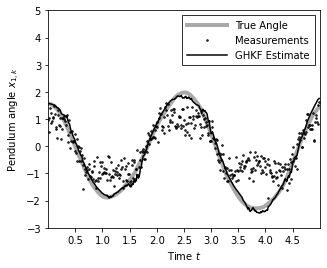

In [15]:
# Compute GHKF estimates
m_ghkf, P_ghkf = ghkf_additive(*(params.to_tuple()), p=10, Y=obs)

# Plot generated data
plot.plot_pendulum(time_grid, states[:,0], obs, x_est=m_ghkf[:,0], est_type="GHKF")

In [16]:
utils.compute_and_print_rmse_comparison(states[:,0], m_ghkf[:,0], params.R, "GHKF")

The RMSE of the GHKF estimate is        : 0.15,
The std of measurement noise is         : 0.55


##6.6 Cubature Kalman Filter

Note that the CKF implementation using Cholesky decomposition leads to a non-positive definite covariance matrix $\textbf{P}_{k-1}$, for which Cholesky decomposition is not well-defined.

Instead, we use the square-root CKF introduced in [Advanced Square-Root Cubature Kalman Filters based on Singular Value Decomposition and Sequential Processing](https://ietresearch.onlinelibrary.wiley.com/doi/10.1049/iet-rsn.2019.0115) to instead use SVD to compute $\sqrt{\textbf{P}_{k-1}} = \textbf{U} \sqrt{\textbf{S}}$, where $\textbf{P}_{k-1} = \textbf{USV}$ is its singular-value decomposition.

In [18]:
# Additive CKF (Algorithm 6.9)
def ckf_additive(m_0, P_0, f, h, Q, R, Y):
    num_timesteps, n = len(Y), P_0.shape[0]

    # Helper function
    def compute_sigmas(m, P, n):
        U, S, _ = jnp.linalg.svd(P)
        disc = jnp.sqrt(n) * (U @ jnp.diag(jnp.sqrt(S)))
        sigma_plus = jnp.array([m + disc[i,:] for i in range(n)])
        sigma_minus = jnp.array([m - disc[i,:] for i in range(n)])
        return jnp.concatenate((sigma_plus, sigma_minus))

    def _step(carry, t):
        m_k, P_k = carry

        # Prediction step:
        # 1. Form sigma points
        sigmas_pred = compute_sigmas(m_k, P_k, n)
        # 2. Propagate the sigma points
        sigmas_pred = jax.vmap(f, 0, 0)(sigmas_pred)
        # 3. Compute predicted mean and covariance
        m_pred = jnp.mean(sigmas_pred, axis=0)
        outer = lambda x, y: jnp.atleast_2d(x).T @ jnp.atleast_2d(y)
        outer = jax.vmap(outer, 0, 0)
        P_pred = jnp.mean(outer(sigmas_pred-m_pred, sigmas_pred-m_pred), 
                          axis=0) + Q

        # Update step:
        # 1. Form sigma points
        sigmas_update = compute_sigmas(m_pred, P_pred, n)
        # 2. Propagate the sigma points
        sigmas_update_prop = jax.vmap(h, 0, 0)(sigmas_update)
        # 3. Compute params
        mu = jnp.mean(sigmas_update_prop, axis=0)
        S = jnp.mean(outer(sigmas_update_prop-mu, sigmas_update_prop-mu), 
                     axis=0) + R
        C = jnp.mean(outer(sigmas_update-m_pred, sigmas_update_prop-mu), axis=0)

        # 4. Compute posterior
        K = C @ jnp.linalg.inv(S)
        m_post = m_pred + K @ (Y[t] - mu)
        P_post = P_pred - K @ S @ K.T
        
        return (m_post, P_post), (m_post, P_post)

    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

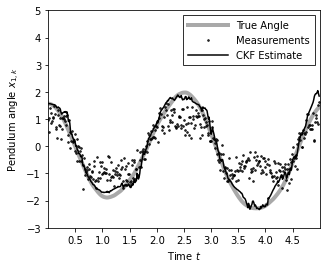

In [20]:
# Compute CKF estimates
m_ckf, P_ckf = ckf_additive(*(params.to_tuple()), obs)

# Plot the results
plot.plot_pendulum(time_grid, states[:,0], obs, x_est=m_ckf[:,0], est_type="CKF")

In [21]:
utils.compute_and_print_rmse_comparison(states[:,0], m_ckf[:,0], params.R, "CKF")

The RMSE of the CKF estimate is         : 0.22,
The std of measurement noise is         : 0.55
